## b345 - 16/02/2008 - CLPX-2 -MARSS

Here we are comparing MARSS (Microwave Airborne Radiometer Scanning System) emissivity measurements from the FAAM aircraft with some radar data taking from a satellite. The data were provided by Chawn Harlow. The original MARSS data are in csv format. Although it is possible to write your own plugin in many cases it might be easier to convert the data into a netCDF, which cis natively supports.

In [1]:
%matplotlib inline

import datetime
import os

ROOT_DATA_PATH = '/home/axel/Dropbox/cis_workshop/data/b345'

# date of flight
year, month, day = 2008, 2, 16

### Converting the MARSS data from csv to netCDF

The MARSS data come as a text file in csv format. We use pandas to read in the data into a DataFrame first.

In [2]:
import pandas as pd

# Date parser, which will give use a datetime object for every data line in the MARSS data
# the first column in the csv file is seconds past midnight
dateparser = lambda x: datetime.datetime(year, month, day)+datetime.timedelta(seconds=int(float(x)))

# column definition for the txt file
colnames=['time', 'lat', 'lon', 'emis89', 'emis157', 'emis183']
ifile = os.path.join(ROOT_DATA_PATH, 'marss_emiss_b345.txt')
df = pd.read_csv(ifile, names=colnames, skiprows=1, parse_dates=[0,], date_parser=dateparser)
df.set_index('time', inplace=True)

Now the data are all in a dataframe. In a next step we create a new xarray dataset from scratch.

In [3]:
import xarray as xr

OVERWRITE_NETCDF = False

# Create a xarray Dataset
ds = xr.Dataset({'emis89':  (('time',), df.emis89),
                 'emis157': (('time',), df.emis157),
                 'emis183': (('time',), df.emis183)},
                  coords={'longitude': df.lon, 'latitude': df.lat, 'time': df.index})

# Add attributes for coordinate variables
ds.longitude.attrs['units']='degree_east'
ds.longitude.attrs['standard_name'] = 'longitude'

ds.latitude.attrs['units']='degree_north'
ds.latitude.attrs['standard_name'] = 'latitude'

# create filename for the output
ofile = ifile[:-3]+'nc'
# delete file if required
if (os.path.exists(ofile) and OVERWRITE_NETCDF):
    os.remove(ofile)

# Write the dataset to netCDF
if not os.path.exists(ofile):
    ds.to_netcdf(path=ofile)

Now that the data are in a suitable format that we can read it in with cis.

In [4]:
import cis

# Read in all variables
b345 = cis.read_data_list(ofile, ['emis89', 'emis157', 'emis183'])
# Print information about dataset
print(b345)

# TODO: Plot data on a map
# b345.plot()

GriddedDataList: 
0: emis89 / (1)                        (time: 1745)
1: emis157 / (1)                       (time: 1745)
2: emis183 / (1)                       (time: 1745)


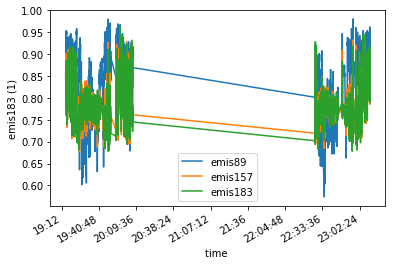

In [5]:
# Time series plot
b345.plot(xaxis='time')

### Converting the Satellite data

Now we deal with the satellite data. Once more we convert the data into a cis suitable format. The original data are in geotiff format, which is converted in a two step process into a netCDF using gdal tools. 

The first step is to to warp the data into the EPSG:4326, projection which will give us longitude and latitude as dimensions (coordinates):

In [6]:
# !gdalwarp -t_srs EPSG:4326 R164129269G3Q001_aoi_sigma_dB.tif R164129269G3Q001_aoi_sigma_dB.4326.tif

In a second step we convert the dataset to netCDF:

In [7]:
 # !gdal_translate -of netCDF R164129269G3Q001_aoi_sigma_dB.4326.tif R164129269G3Q001_aoi_sigma_dB.4326.nc

Let's have a quick look what is in the file:

In [8]:
# !ncdump -h R164129269G3Q001_aoi_sigma_dB.4326.nc

Rename the variable to aoi:

In [ ]:
# !ncrename -v Band1,aoi R164129269G3Q001_aoi_sigma_dB.4326.nc

### CIS

Plot the satellite data as a heatmap, which is the default type for a gridded dataset.

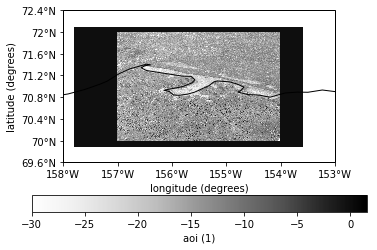

In [8]:
aoi_ifile = os.path.join(ROOT_DATA_PATH, 'R164129269G3Q001_aoi_sigma_dB.4326.nc')
aoi = cis.read_data(aoi_ifile, 'aoi')
ax = aoi.plot(cmap='Greys')

In [10]:
# TODO: Not working from here on

# plot the MARSS data on top
b345.plot(ax=ax)

x_rng = [-157, -154, 0.05]
y_rng = [70, 72, 0.05]
b345_agg = b345.aggregate(how='mean', x=x_rng, y=y_rng)
print(b345_agg)

AttributeError: 'GriddedDataList' object has no attribute 'aggregate'

In [ ]:
aoi_agg = aoi.collocated_onto(b345_agg[0])

import matplotlib.pyplot as plt
plt.figure()
ax = plt.subplot()
for i in range(3):
    ax.plot(b345_agg[i].data[:].ravel(), aoi_agg[0].data[:].ravel(), '.', label=b345_agg.var_name[i])

ax.legend()
ax.set_xlabel('MARSS')
ax.set_ylabel('aoi (db)')

/usr/local/lib/python2.7/dist-packages/Iris-1.12.0.dev0-py2.7.egg/iris/coords.py:802: UserWarning: Coordinate u'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/usr/local/lib/python2.7/dist-packages/Iris-1.12.0.dev0-py2.7.egg/iris/coords.py:802: UserWarning: Coordinate u'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


AttributeError: 'GriddedDataList' object has no attribute 'aggregate'

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/